In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3213, done.
remote: Total 3213 (delta 0), reused 0 (delta 0), pack-reused 3213
Receiving objects: 100% (3213/3213), 582.57 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
Checking out files: 100% (991/991), done.


In [ ]:
!mkdir -p /content/dataset/covid/
!mkdir -p /content/dataset/normal/
!mkdir -p /content/dataset/pneumonia/

In [ ]:
!unzip "/content/drive/My Drive/Datasets/Chest X-Ray Images (Pneumonia).zip"

In [ ]:
!mv /content/chest_xray/train/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/train/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/val/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/val/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/test/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/test/PNEUMONIA/* /content/dataset/pneumonia/

In [ ]:
import pandas as pd
import shutil
import os

# Selecting all combination of 'COVID-19' patients with 'PA' X-Ray view
virus = "COVID-19" # Virus to look for
x_ray_view = "PA" # View of X-Ray

meta_data = "/content/covid-chestxray-dataset/metadata.csv"
images_dir = "/content/covid-chestxray-dataset/images"
output_dir = "/content/dataset/covid/"

metadata_csv = pd.read_csv(meta_data)

for (i, row) in metadata_csv.iterrows():
	if row["finding"] != virus or row["view"] != x_ray_view:
		continue

	filename = row["filename"].split(os.path.sep)[-1]
	filePath = os.path.sep.join([images_dir, filename])
	shutil.copy2(filePath, output_dir)

  ## Pre-processing 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, average, Average
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201
from keras.applications import MobileNet
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import time

import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [ ]:
DATASET_DIR = "/content/dataset"

NORMAL_DIR = DATASET_DIR + "/normal"
PNEUMONIA_DIR = DATASET_DIR + "/pneumonia"
COVID_DIR = DATASET_DIR + "/covid"

NORMAL_TRAIN_SAMPLES = 1200 # total samples = 1583
PNEUMONIA_TRAIN_SAMPLES = 2000 # total samples = 4273
COVID_TRAIN_SAMPLES = 160 # total samples = 201

IMG_W = 224
IMG_H = 224
IMG_C = 1
INPUT_SHAPE = (IMG_W, IMG_H, IMG_C)

CLASSES = [ "NORMAL", "PNEUMONIA", "COVID" ]
NB_CLASSES = len(CLASSES)

EPOCHS = 10
BATCH_SIZE = 16

In [ ]:
normal_images = []
pneumonia_images = []
covid_images = []

In [ ]:
for img_path in glob.glob(NORMAL_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    normal_images.append(img[:np.newaxis])

for img_path in glob.glob(PNEUMONIA_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    pneumonia_images.append(img[:np.newaxis])

for img_path in glob.glob(COVID_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    covid_images.append(img[:np.newaxis])

In [ ]:
len(normal_images), len(pneumonia_images), len(covid_images)

(1583, 4273, 201)

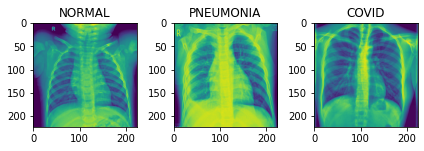

In [ ]:
width=150
height=150
rows = 1
cols = 3

imgs = [ normal_images[0], pneumonia_images[0], covid_images[0]]

axes=[]
fig=plt.figure()

for i in range(rows*cols):
    img = imgs[i]
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img)

axes[0].set_title('NORMAL')
axes[1].set_title('PNEUMONIA')
axes[2].set_title('COVID')
fig.tight_layout()    
plt.show()

In [ ]:
normal_X = []
pneumonia_X = []
covid_X = []
normal_y = []
pneumonia_y = []
covid_y = []
X = []
y = []

for item in normal_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    normal_X.append(img)    
    normal_y.append(CLASSES.index("NORMAL"))   
    X.append(img)    
    y.append(CLASSES.index("NORMAL"))

for item in pneumonia_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    pneumonia_X.append(img)    
    pneumonia_y.append(CLASSES.index("PNEUMONIA"))   
    X.append(img)    
    y.append(CLASSES.index("PNEUMONIA"))

for item in covid_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    covid_X.append(img) 
    covid_y.append(CLASSES.index("COVID"))   
    X.append(img)    
    y.append(CLASSES.index("COVID"))

X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape, y.shape

((6057, 224, 224, 1), (6057,))

In [ ]:
# X = X / 255.

In [ ]:
# from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(
# #     X, y, test_size=0.2, random_state=2020)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
X_train_normal = normal_X[:NORMAL_TRAIN_SAMPLES]
X_train_pneumonia = pneumonia_X[:PNEUMONIA_TRAIN_SAMPLES]
X_train_covid = covid_X[:COVID_TRAIN_SAMPLES]
X_test_normal = normal_X[NORMAL_TRAIN_SAMPLES:]
X_test_pneumonia = pneumonia_X[PNEUMONIA_TRAIN_SAMPLES:]
X_test_covid = covid_X[COVID_TRAIN_SAMPLES:]

y_train_normal = normal_y[:NORMAL_TRAIN_SAMPLES]
y_train_pneumonia = pneumonia_y[:PNEUMONIA_TRAIN_SAMPLES]
y_train_covid = covid_y[:COVID_TRAIN_SAMPLES]
y_test_normal = normal_y[NORMAL_TRAIN_SAMPLES:]
y_test_pneumonia = pneumonia_y[PNEUMONIA_TRAIN_SAMPLES:]
y_test_covid = covid_y[COVID_TRAIN_SAMPLES:]


X_train = np.concatenate((X_train_normal, X_train_pneumonia, X_train_covid), axis=0) 
y_train = np.concatenate((y_train_normal, y_train_pneumonia, y_train_covid), axis=0) 

X_test = np.concatenate((X_test_normal, X_test_pneumonia, X_test_covid), axis=0) 
y_test = np.concatenate((y_test_normal, y_test_pneumonia, y_test_covid), axis=0) 

In [ ]:
a = list(zip(X_train, y_train))
random.shuffle(a)
X_train, y_train = zip(*a)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
X_train.shape, y_train.shape

((2688, 224, 224, 1), (2688,))

In [ ]:
X_val.shape, y_val.shape

((672, 224, 224, 1), (672,))

In [ ]:
X_test.shape, y_test.shape

((2697, 224, 224, 1), (2697,))

In [ ]:
# # da_args = dict(rescale=1./255, 
# #                shear_range=0.2,
# #                zoom_range=0.2,
# #                horizontal_flip=True)
# # da = ImageDataGenerator(da_args)

# # With data augmentation to prevent overfitting and handling the imbalance in dataset
# data_gen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# data_gen.fit(X_train)
# X_val, y_val = datagen.flow(X_val, y_val)


# # val_da_args = dict(rescale=1./255)
# # val_da = ImageDataGenerator(val_da_args)

# # train_data = da.flow_from_directory(
# #     TRAIN_DIR,
# #     target_size=(IMG_H, IMG_W),
# #     batch_size=BATCH_SIZE,
# #     class_mode='binary') 

# # val_data = val_da.flow_from_directory(
# #     VAL_DIR, 
# #     target_size=(IMG_H, IMG_W), 
# #     batch_size=BATCH_SIZE,
# #     shuffle=False,
# #     class_mode='binary')

# # test_data = val_da.flow_from_directory(
# #     TEST_DIR, 
# #     target_size=(IMG_H, IMG_W), 
# #     batch_size=BATCH_SIZE, 
# #     shuffle=False,
# #     class_mode='binary')

In [ ]:
# Normalize the data
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [ ]:
# Create 3-channels images
X_train = np.repeat(X_train[...,], 3, 3)
X_val = np.repeat(X_val[...,], 3, 3)
X_test = np.repeat(X_test[...,], 3, 3)

In [ ]:
X_train.shape, y_train.shape

((2688, 224, 224, 3), (2688, 3))

In [ ]:
X_val.shape, y_val.shape

((672, 224, 224, 3), (672, 3))

In [ ]:
X_test.shape, y_test.shape

((2697, 224, 224, 3), (2697, 3))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 964, 1587,  137]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([ 383, 2273,   41]))

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(NB_CLASSES))
# model.add(Activation('softmax'))

In [ ]:
# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_shape=(IMG_H, IMG_W, 3))

# for layer in vgg_model.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

# model = Sequential()
# model.add(vgg_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(NB_CLASSES, activation='softmax'))

In [ ]:
# models_input = Input(shape=(IMG_H, IMG_W, 3))


# resnet_model = ResNet50(weights='imagenet', 
#                         include_top=False, 
#                         input_tensor=models_input)

# for layer in resnet_model.layers:
#     layer.name = "resnet50_" + layer.name
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
        
# resnet_gap = GlobalAveragePooling2D()(resnet_model.output)
# # x = Dense(256)(x)
# # x = Activation('relu')(x)
# # x = Dropout(0.5)(x)
# # x = Activation('relu')(x)
# # x = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(resnet_gap)
# out = Activation('softmax')(x)
# model = Model(inputs=resnet_model.input, outputs=out)


# # vgg_model = VGG16(weights='imagenet', 
# #                         include_top=False, 
# #                         input_tensor=models_input)

# # for layer in vgg_model.layers:
# #     layer.name = "vgg16_" + layer.name
# #     if isinstance(layer, BatchNormalization):
# #         layer.trainable = True
# #     else:
# #         layer.trainable = False

        
# # vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# # # x = GlobalAveragePooling2D()(vgg_model.output)
# # x = Dense(256)(vgg_gap)
# # x = Activation('relu')(x)
# # x = Dropout(0.5)(x)
# # x = Activation('relu')(x)
# # vgg_out = BatchNormalization()(x)
# # x = Dense(NB_CLASSES)(x)
# # out = Activation('softmax')(x)

# # Merging subnetworks
# # merged_nets = concatenate([vgg_gap, densenet_gap])

# # x = Dense(NB_CLASSES)(merged_nets)
# # out = Activation('softmax')(x)

# # inputs = input_tensor=models_input
# # outputs = resnet_model # out # average([resnet_model.output, vgg_model.output])
# # model = Model(inputs, outputs)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
models_input = Input(shape=(IMG_H, IMG_W, 3))


resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in resnet_model.layers:
    layer.name = "resnet50_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
        
resnet_gap = GlobalAveragePooling2D()(resnet_model.output)
# x = Dense(256)(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
x = Dense(NB_CLASSES)(resnet_gap)
out = Activation('softmax')(x)
model = Model(inputs=resnet_model.input, outputs=out)


# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_tensor=models_input)

# for layer in vgg_model.layers:
#     layer.name = "vgg16_" + layer.name
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

        
# vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# # x = GlobalAveragePooling2D()(vgg_model.output)
# x = Dense(256)(vgg_gap)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# vgg_out = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(x)
# out = Activation('softmax')(x)

# Merging subnetworks
# merged_nets = concatenate([vgg_gap, densenet_gap])

# x = Dense(NB_CLASSES)(merged_nets)
# out = Activation('softmax')(x)

# inputs = input_tensor=models_input
# outputs = resnet_model # out # average([resnet_model.output, vgg_model.output])
# model = Model(inputs, outputs)

In [ ]:
models_input = Input(shape=(IMG_H, IMG_W, 3))


# resnet_model = ResNet50(weights='imagenet', 
#                         include_top=False, 
#                         input_tensor=models_input)

# for layer in resnet_model.layers:
#     layer.name = "resnet50_" + layer.name
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
        
# resnet_gap = GlobalAveragePooling2D()(resnet_model.output)
# # x = Dense(256)(x)
# # x = Activation('relu')(x)
# # x = Dropout(0.5)(x)
# # x = Activation('relu')(x)
# # x = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(resnet_gap)
# out = Activation('softmax')(x)
# model = Model(inputs=resnet_model.input, outputs=out)


vgg_model = VGG16(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in vgg_model.layers:
    layer.name = "vgg16_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

        
vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# x = GlobalAveragePooling2D()(vgg_model.output)
# x = Dense(256)(vgg_gap)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
x = Dense(NB_CLASSES)(vgg_gap)
out = Activation('softmax')(x)
model = Model(inputs=vgg_model.input, outputs=out)

# Merging subnetworks
# merged_nets = concatenate([vgg_gap, densenet_gap])

# x = Dense(NB_CLASSES)(merged_nets)
# out = Activation('softmax')(x)

# inputs = input_tensor=models_input
# outputs = resnet_model # out # average([resnet_model.output, vgg_model.output])
# model = Model(inputs, outputs)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input_6 (InputLayer)   (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16_block1_conv1 (Conv2D)  (None, 224, 224, 64)      1792      
_________________________________________________________________
vgg16_block1_conv2 (Conv2D)  (None, 224, 224, 64)      36928     
_________________________________________________________________
vgg16_block1_pool (MaxPoolin (None, 112, 112, 64)      0         
_________________________________________________________________
vgg16_block2_conv1 (Conv2D)  (None, 112, 112, 128)     73856     
_________________________________________________________________
vgg16_block2_conv2 (Conv2D)  (None, 112, 112, 128)     147584    
_________________________________________________________________
vgg16_block2_pool (MaxPoolin (None, 56, 56, 128)       0   

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS, 
                 verbose=1, 
                 callbacks=None, 
                 validation_data=(X_val, y_val))

Train on 2688 samples, validate on 672 samples
Epoch 1/10
2688/2688 [==============================] - 37s 14ms/step - loss: 0.7438 - accuracy: 0.6834 - val_loss: 0.5713 - val_accuracy: 0.8244
Epoch 2/10
2688/2688 [==============================] - 35s 13ms/step - loss: 0.5520 - accuracy: 0.8419 - val_loss: 0.4787 - val_accuracy: 0.8363
Epoch 3/10
2688/2688 [==============================] - 35s 13ms/step - loss: 0.4705 - accuracy: 0.8616 - val_loss: 0.4334 - val_accuracy: 0.8497
Epoch 4/10
2688/2688 [==============================] - 35s 13ms/step - loss: 0.4175 - accuracy: 0.8657 - val_loss: 0.3944 - val_accuracy: 0.8646
Epoch 5/10
2688/2688 [==============================] - 35s 13ms/step - loss: 0.3788 - accuracy: 0.8698 - val_loss: 0.3718 - val_accuracy: 0.8631
Epoch 6/10
2688/2688 [==============================] - 35s 13ms/step - loss: 0.3480 - accuracy: 0.8769 - val_loss: 0.3476 - val_accuracy: 0.8720
Epoch 7/10
2688/2688 [==============================] - 35s 13ms/step - loss:

In [ ]:
model.evaluate(X_test, y_test)

2697/2697 [==============================] - 26s 10ms/step


[0.22055978526616477, 0.931034505367279]

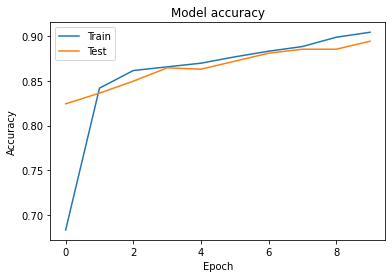

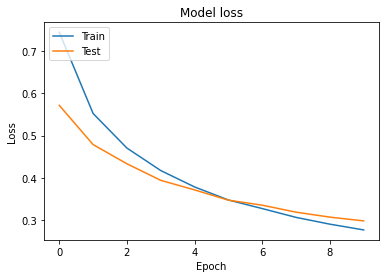

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Confusion matrix
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
    thresh = np.max(cm) // 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

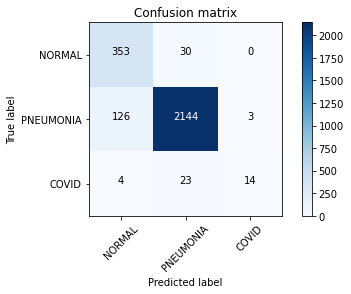

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = CLASSES)

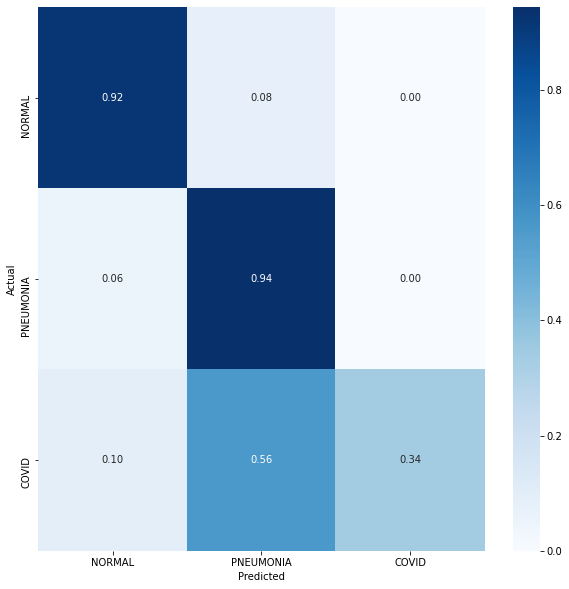

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# Normalise
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [ ]:
model.save_weights('model_weights.h5')

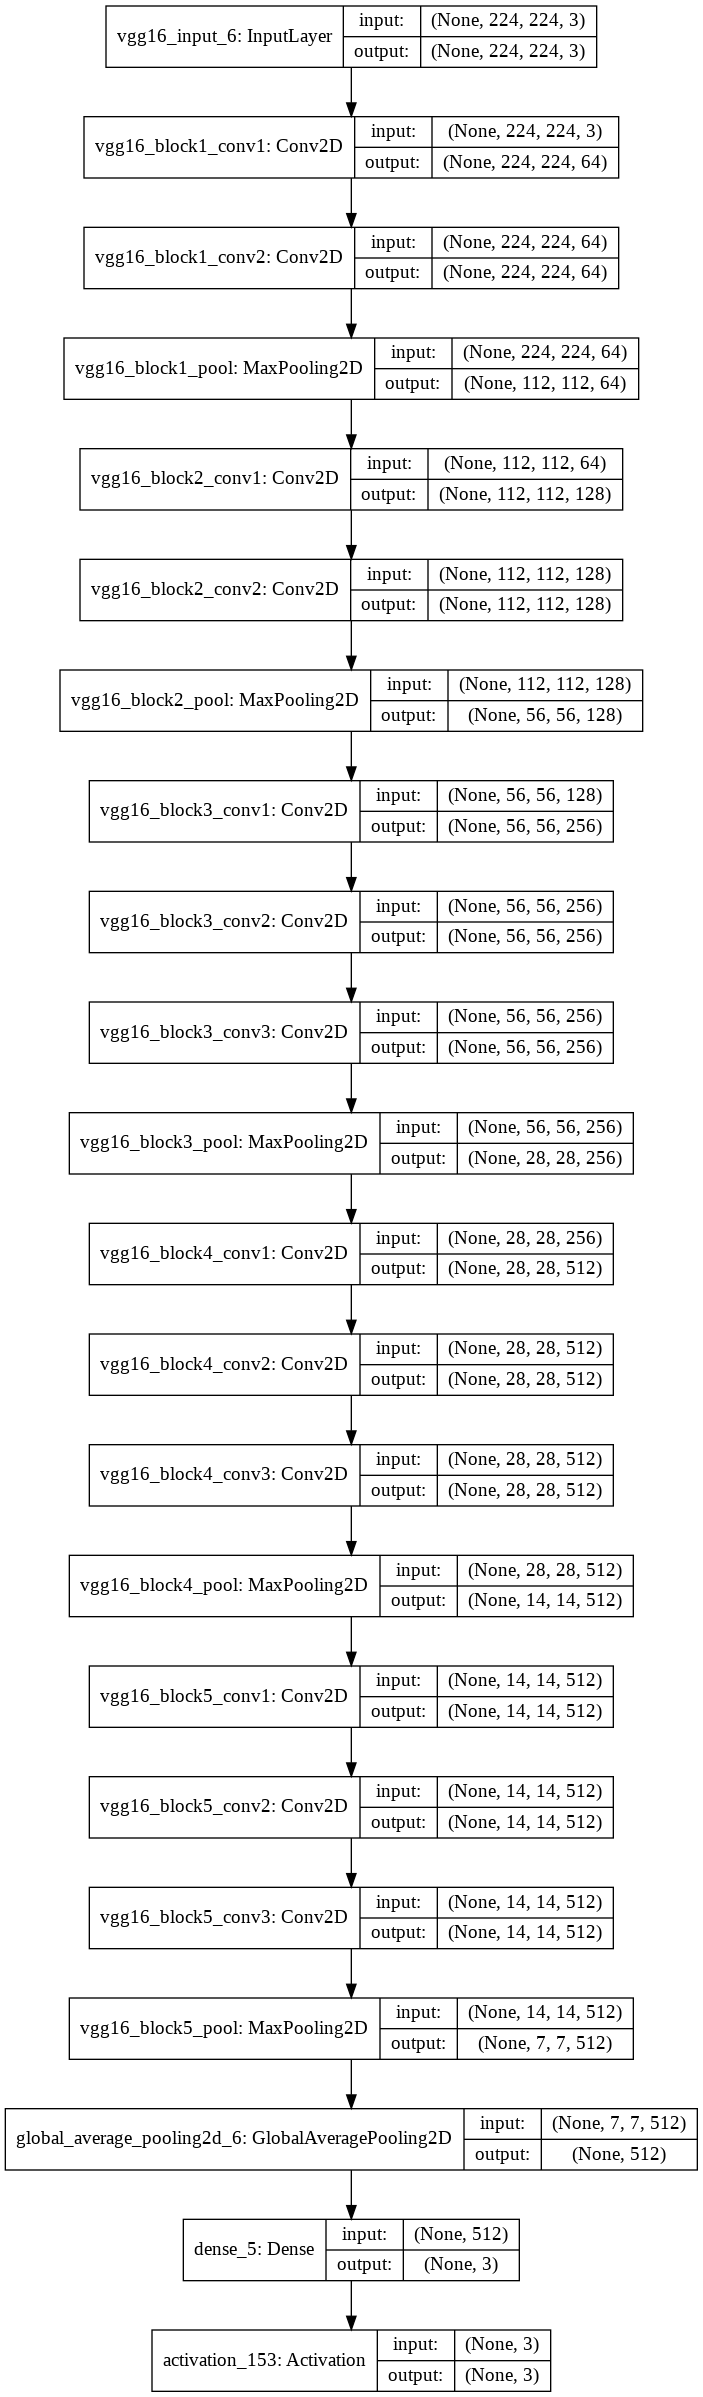

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')